In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

In [2]:
# laod hg38 transcript to gene annotation map

tr2g = {}
trlist = []
g2n = {}
with open('./ref/t2g_kb.txt') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])
        g2n[l[1]] = l[2]

genes = list(set(tr2g[t] for t in tr2g))



# load equivalence classes
# equivalence classes: the Reads aligned to same(ambigiously)
# transcript are considered to be "close", which are generalized into
# the same equivalence class.
ecs = {}
with open('./count_out/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [3]:
# load kallisto bus output dataset
# demonstrate how cell-gene mat is generated

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./count_out/output_unfiltered.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        # Here shows how umi collision collapse in kallisto
        # This collapse methods is different from the description in the paper which result in more detected gene
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [4]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

## Check barcode-gene distribution

4703


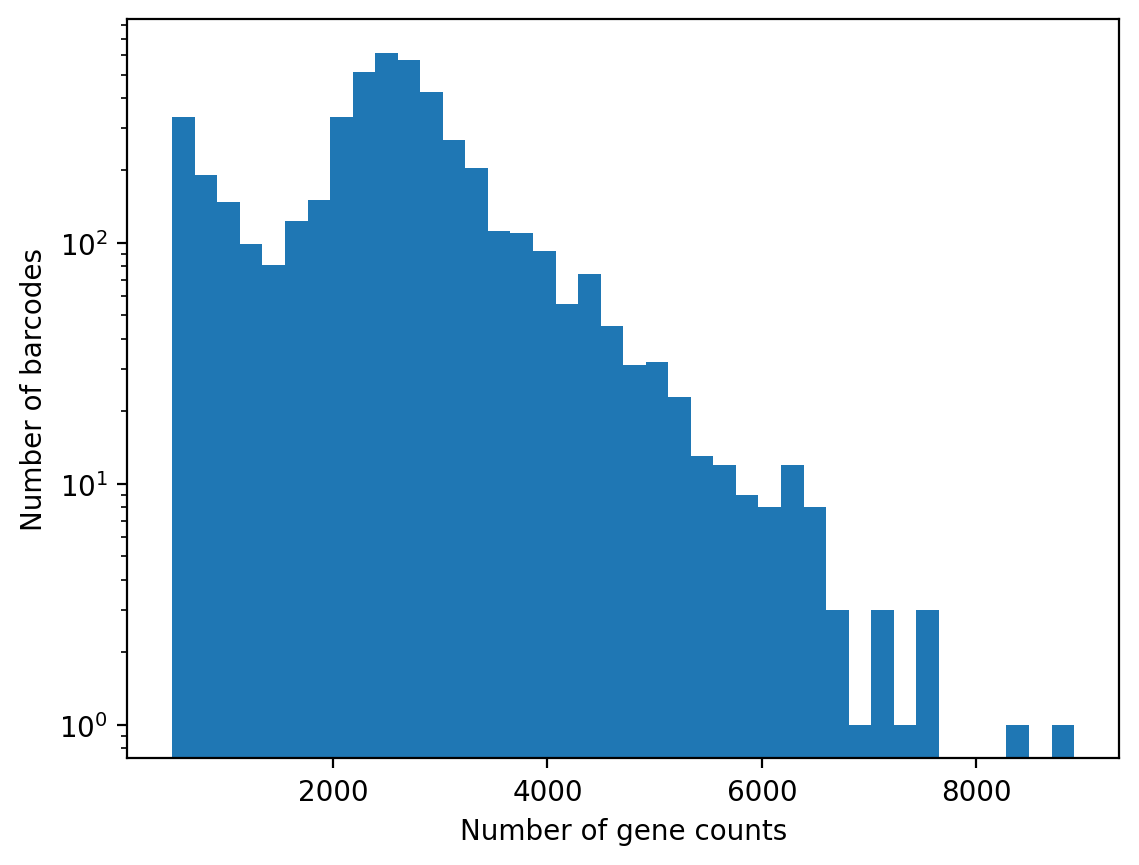

In [5]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > 500] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [6]:
import scanpy as sc
import anndata
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import seaborn as sns

## Import cell-gene count matrix

In [7]:
adata = anndata.read("./count_out/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 147145 × 60623
    var: 'gene_name'

## Unfiltered cell-gene count matrix QC Check

In [8]:
# add mito label for later qc func
adata.var['mito'] = adata.var['gene_name'].str.startswith('MT-')

In [9]:
qc_unfiltered = sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=False)

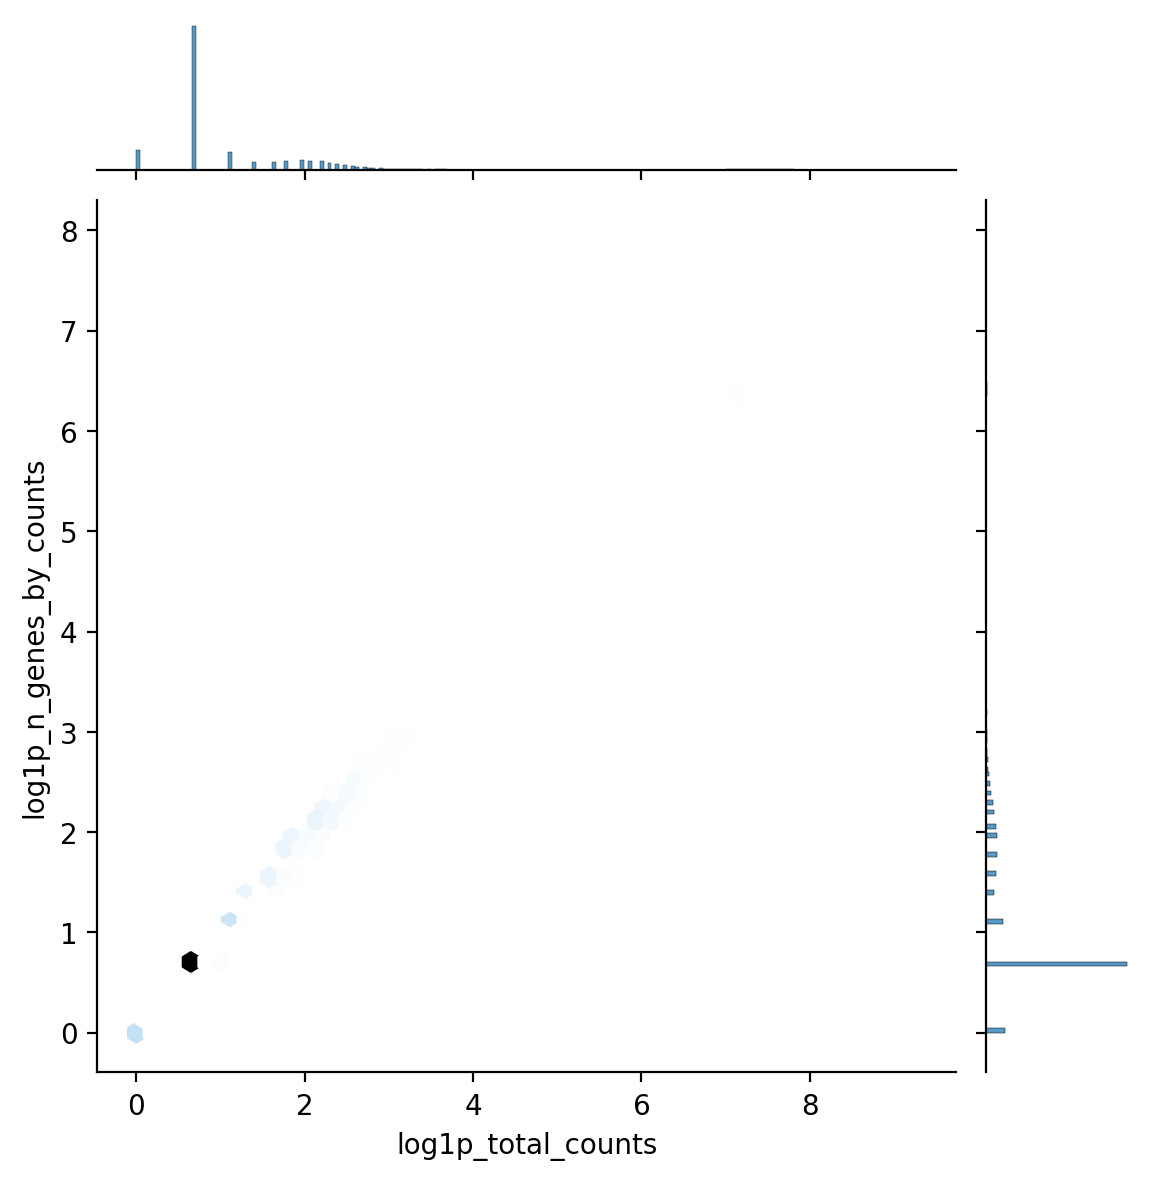

In [10]:
sns.jointplot(
    data=qc_unfiltered[0],
    x='log1p_total_counts',
    y='log1p_n_genes_by_counts',
    kind='hex'
)

In [11]:
qc_unfiltered[0].describe()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
count,147145.000000,147145.000000,147145.000000,147145.000000,136934.000000,136934.000000,136934.000000,136934.000000,147145.000000,147145.000000,136934.000000
mean,23.742404,1.337175,67.052927,1.427063,98.173432,98.762677,99.186314,99.747683,5.969336,0.690622,25.772449
std,121.047606,1.214710,391.657244,1.420786,9.588497,6.873274,4.729814,1.833038,31.713266,1.059604,34.602471
min,0.000000,0.000000,0.000000,0.000000,30.633284,42.857143,56.271186,71.866497,0.000000,0.000000,0.000000
25%,1.000000,0.693147,1.000000,0.693147,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
50%,1.000000,0.693147,1.000000,0.693147,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
75%,6.000000,1.945910,6.000000,1.945910,100.000000,100.000000,100.000000,100.000000,2.000000,1.098612,50.000000
max,2724.000000,7.910224,10676.000000,9.275847,100.000000,100.000000,100.000000,100.000000,1719.000000,7.450080,100.000000


<Axes: xlabel='pct_counts_mito', ylabel='Count'>

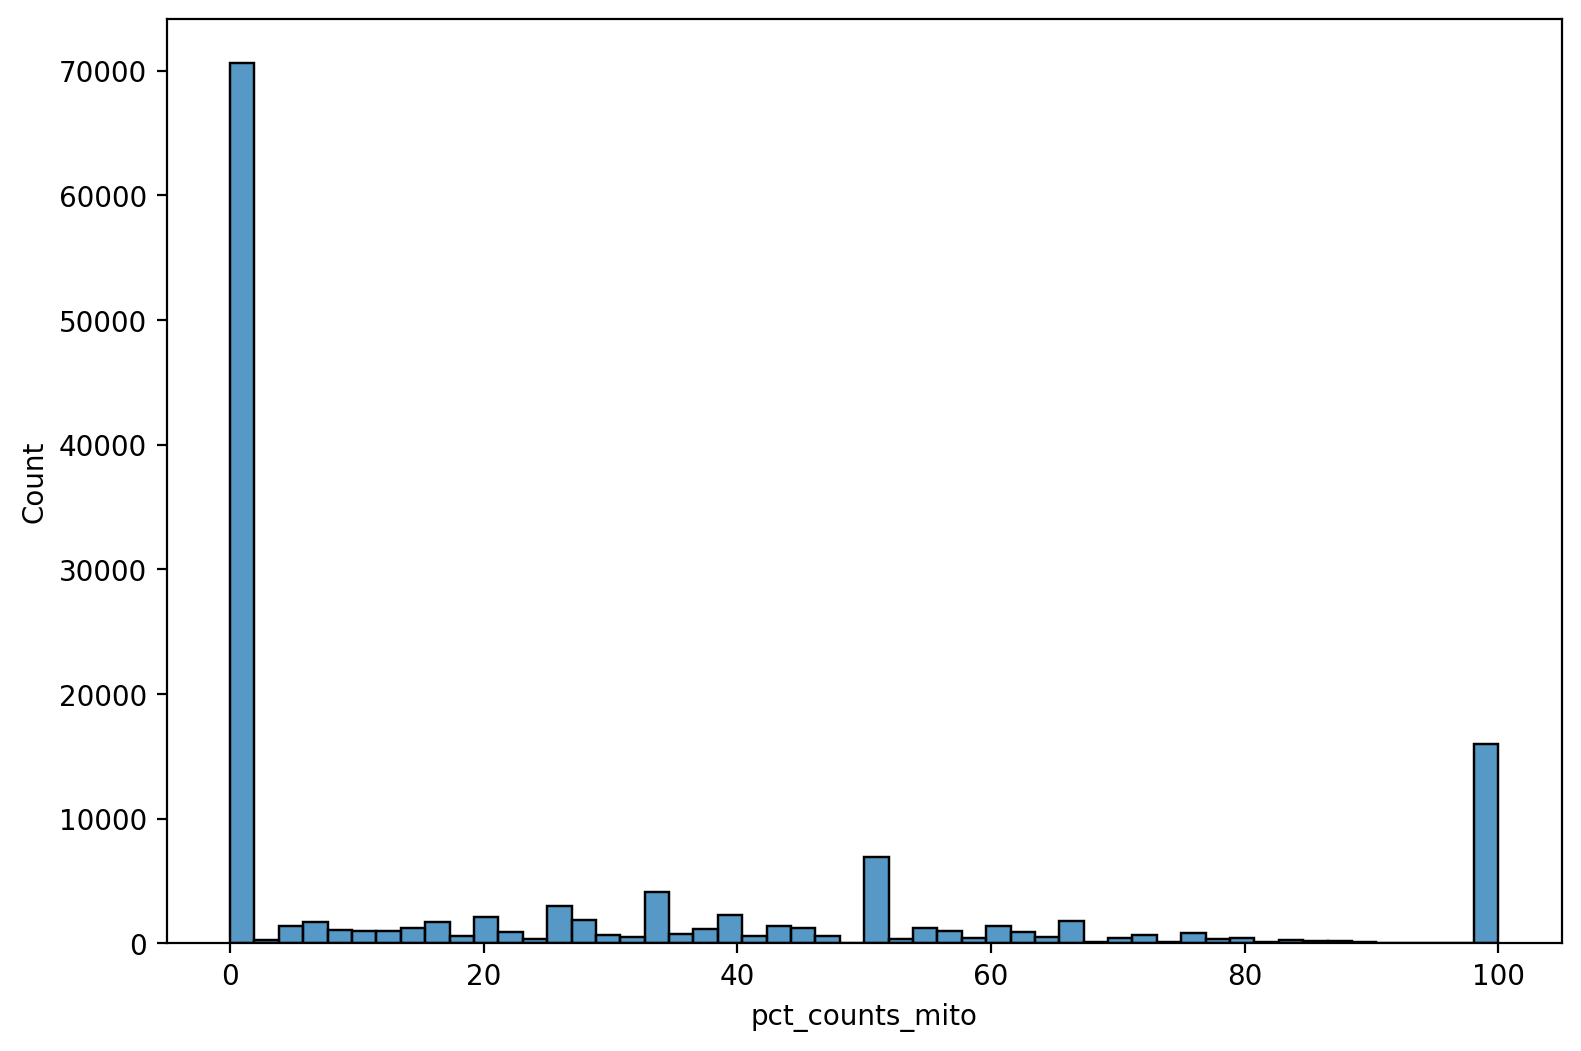

In [12]:
sns.histplot(qc_unfiltered[0]["pct_counts_mito"])

In [13]:
qc_unfiltered[1]['pct_dropout_by_counts'].describe()

count    60623.000000
mean        99.960836
std          0.280424
min         72.110503
25%         99.993884
50%        100.000000
75%        100.000000
max        100.000000
Name: pct_dropout_by_counts, dtype: float64

## Check PCA plot

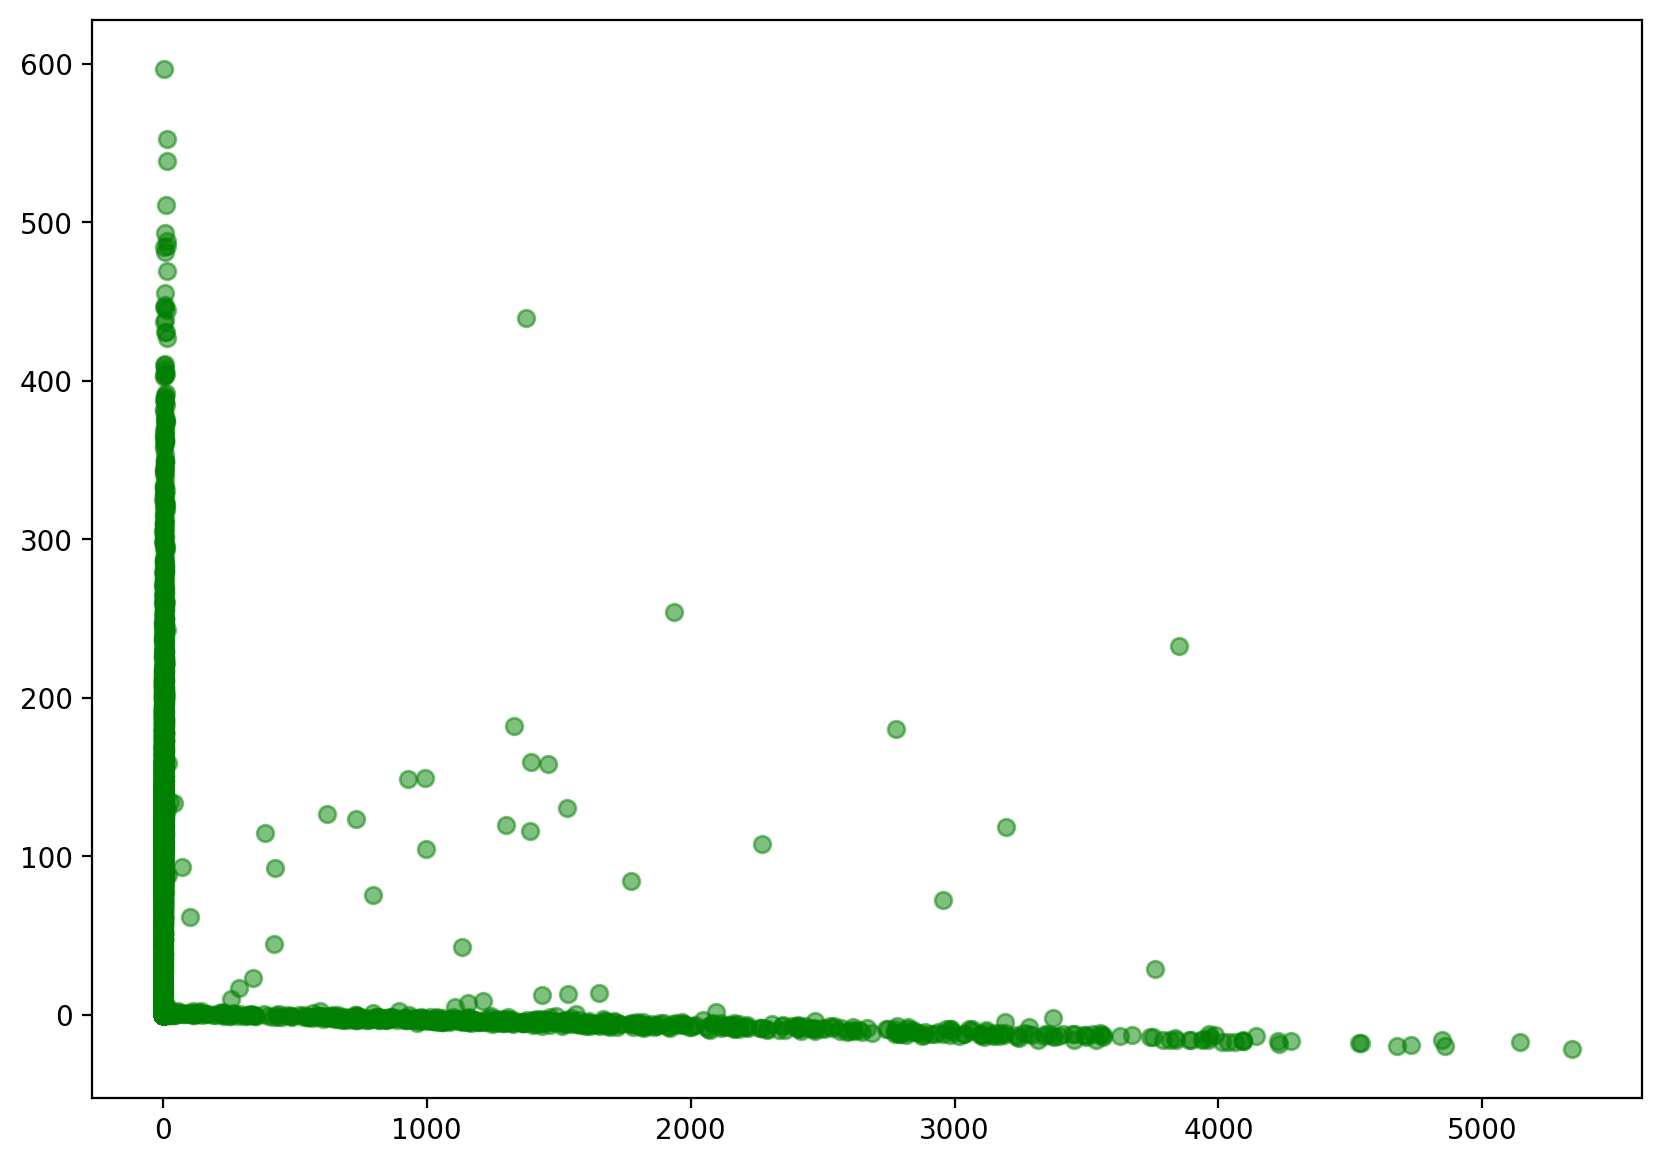

In [14]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.show()

## Library Satruation

TypeError: LogScale.__init__() got an unexpected keyword argument 'nonposy'

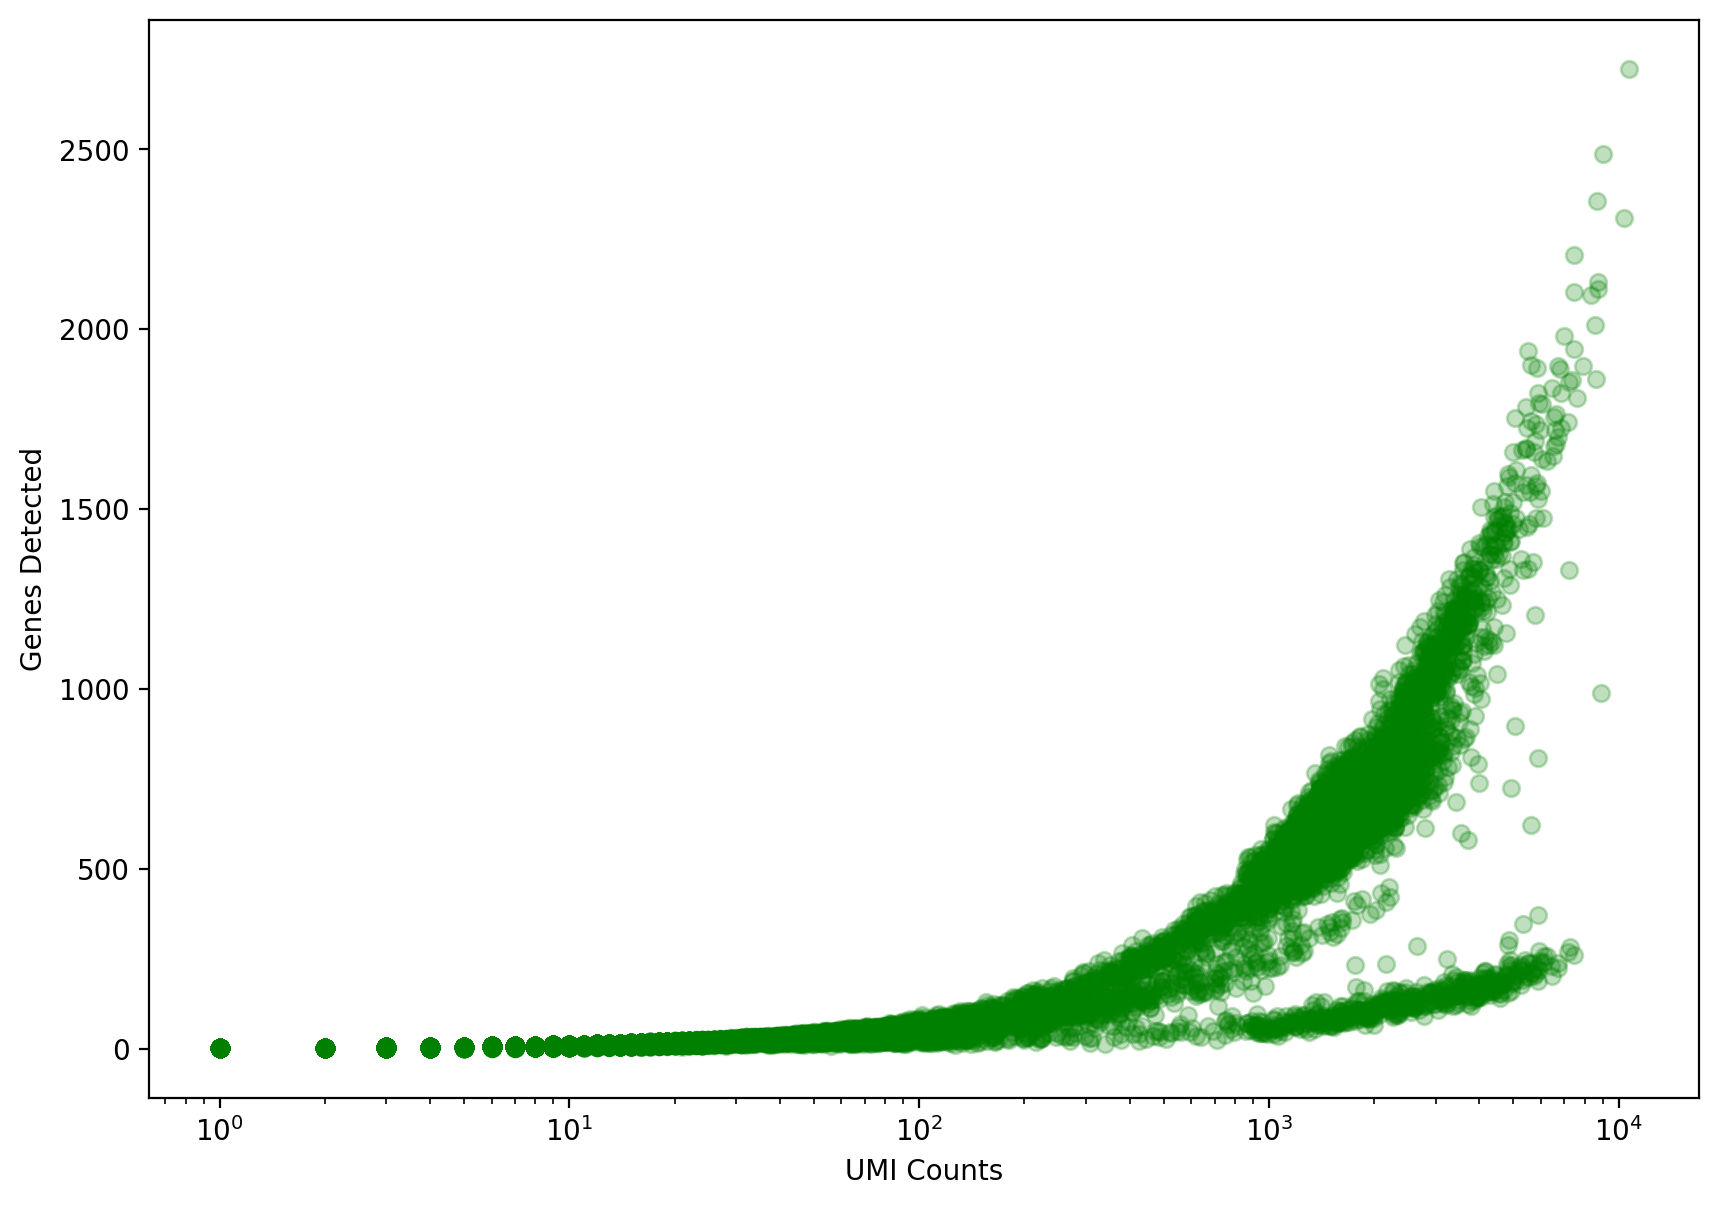

In [15]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

## Knee point

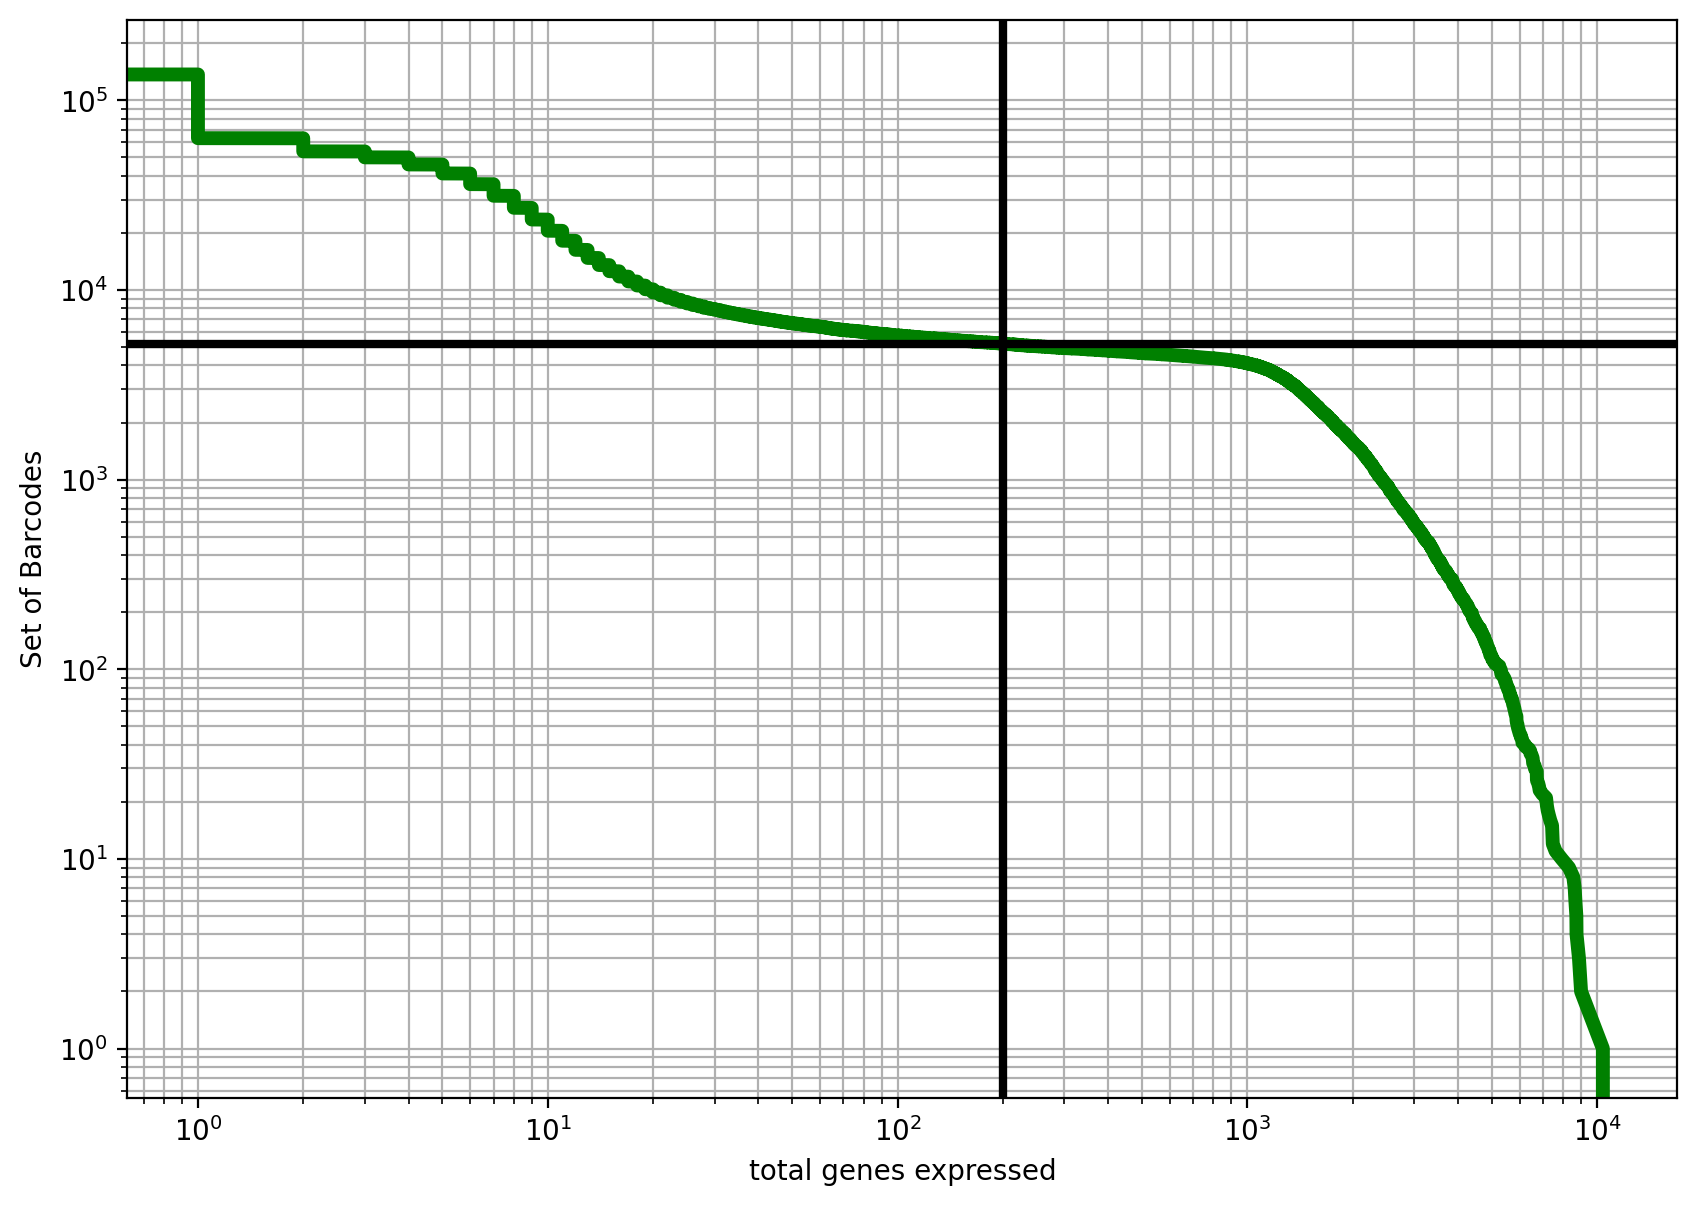

In [16]:
# { run: "auto", vertical-output: true }
# The idea is that "real" cells have a certain number of UMI counts 
# and that a threshold on the UMI counts filters those cells.
cutoff =  200

# option 1 (describe in tutorial)
# desc sorted total gene expressed per cell
knee_1 = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

# optioin 2 (describe in paper)
# we ordered our digital expression matrix by the *total number of transcripts(umi count)* per
# cell barcode, and plotted the cumulative fraction of all transcripts in the matrix for each successively
# smaller cell barcode.
# knee_2 = np.sort((np.array(np.sum(adata.X > 0, axis=1))).flatten())[::-1]

cell_set = np.arange(len(knee_1))
num_cells_1 = cell_set[knee_1 > cutoff][::-1][0]
# num_cells_2 = cell_set[knee_2 > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))

# option 1
ax.loglog(knee_1, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")
ax.axhline(y=num_cells_1, linewidth=3, color="k")
ax.set_xlabel("total genes expressed")
ax.set_ylabel("Set of Barcodes")

# option 2
# ax.loglog(knee_2, cell_set, linewidth=5, color="g")
# ax.axvline(x=cutoff, linewidth=3, color="k")
# ax.axhline(y=num_cells_2, linewidth=3, color="k")
# ax.set_xlabel("umi_count")
# ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [17]:
print(f"{num_cells_1:,.0f} cells passed the {cutoff} UMI threshold")
# print(f"{num_cells_2:,.0f} cells passed the {cutoff} UMI threshold")

5,206 cells passed the 200 UMI threshold


## Filter data

In [18]:
# empty droplets
adata

AnnData object with n_obs × n_vars = 147145 × 60623
    var: 'gene_name', 'mito'

In [19]:
# mito content < .5
# adata = adata[qc_unfiltered[0].pct_counts_mito < 5, :]
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes = 2500)
sc.pp.filter_cells(adata, min_counts=knee_1[num_cells_1])

In [20]:
adata

AnnData object with n_obs × n_vars = 4262 × 60623
    obs: 'n_genes', 'n_counts'
    var: 'gene_name', 'mito'

## QC check after /w filtered matrix

In [21]:
qc_filtered = sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=False)

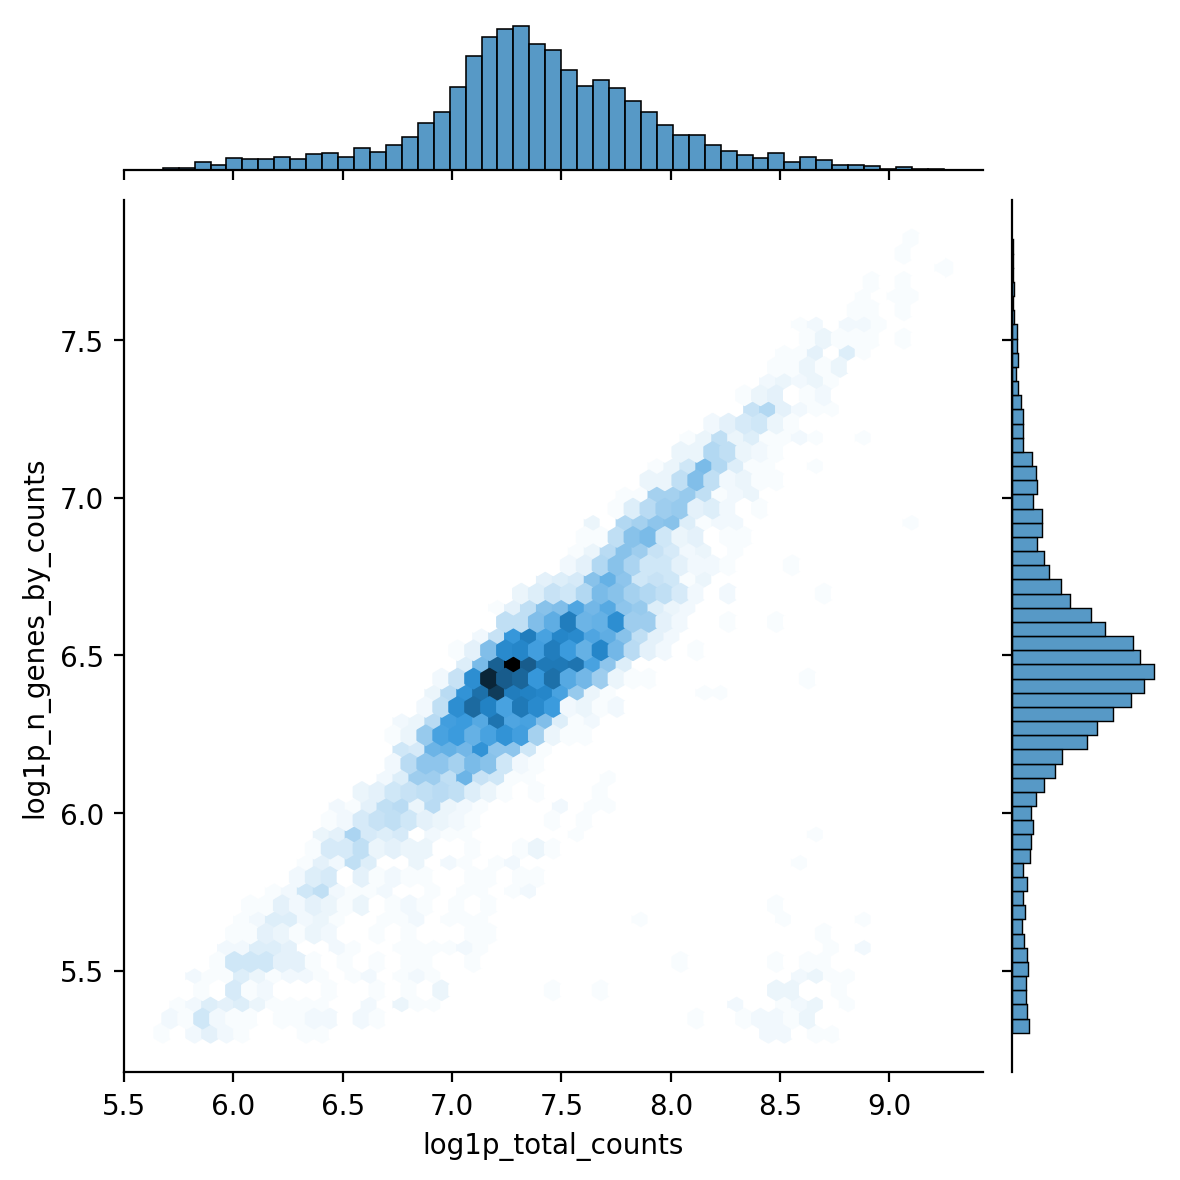

In [22]:
sns.jointplot(
    data=qc_filtered[0],
    x='log1p_total_counts',
    y='log1p_n_genes_by_counts',
    kind='hex'
)

<Axes: xlabel='pct_counts_mito', ylabel='Count'>

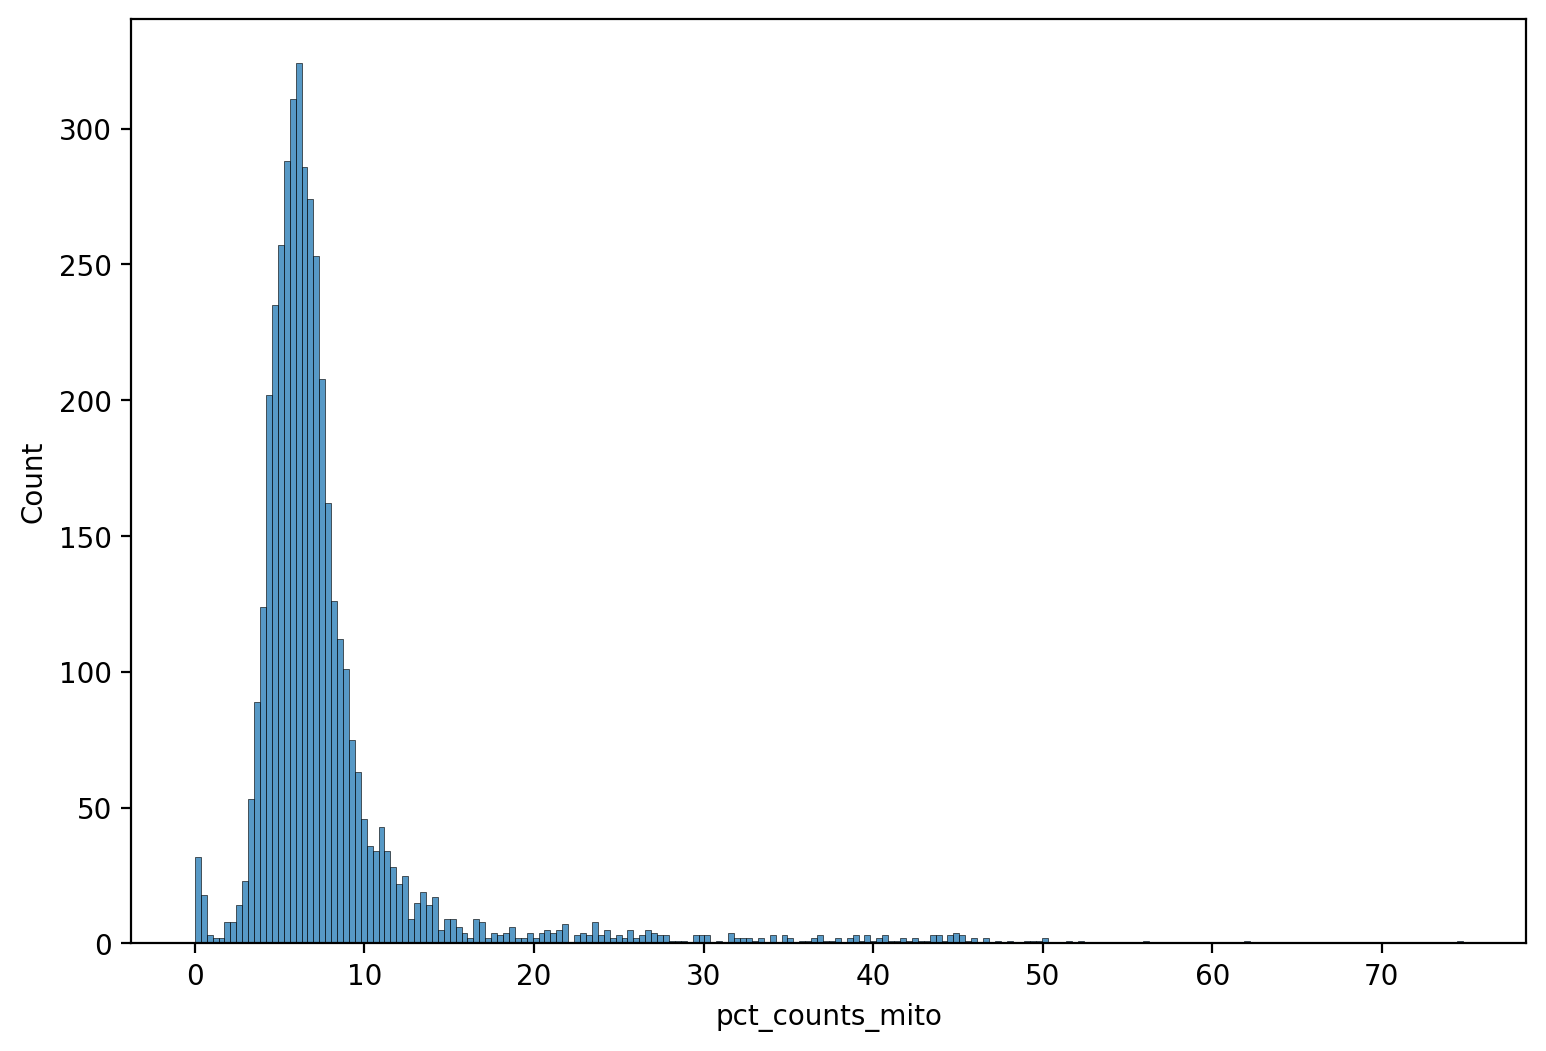

In [23]:
# mitochondria protein gene check
sns.histplot(qc_filtered[0]["pct_counts_mito"])

In [24]:
qc_filtered[1]['pct_dropout_by_counts'].describe()

count    60623.000000
mean        98.902125
std          5.516091
min          0.305021
25%         99.788832
50%        100.000000
75%        100.000000
max        100.000000
Name: pct_dropout_by_counts, dtype: float64

In [25]:
qc_filtered[0]

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
barcode,,,,,,,,,,,
AAACCTGAGCCGGTAA,634,6.453625,1453.0,7.282074,44.528562,58.017894,70.130764,90.777701,105.0,4.663439,7.226428
AAACCTGAGCCTCGTG,652,6.481577,1486.0,7.304516,42.261104,57.335128,69.582773,89.771198,94.0,4.553877,6.325707
AAACCTGCAGCGAACA,502,6.220590,1229.0,7.114769,47.681041,62.978031,75.427177,99.837266,73.0,4.304065,5.939788
AAACCTGGTATAGGGC,585,6.373320,1204.0,7.094235,41.029900,54.734219,68.023256,92.940199,71.0,4.276666,5.897010
AAACCTGGTCTAGCCG,614,6.421622,1283.0,7.157735,43.491816,55.962588,67.731878,91.114575,94.0,4.553877,7.326578
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGGAATTAC,238,5.476464,5503.0,8.613230,96.329275,97.492277,99.309468,100.000000,28.0,3.367296,0.508813
TTTGTCAAGTGCGTGA,530,6.274762,1095.0,6.999422,41.826484,56.894977,69.863014,97.260274,64.0,4.174387,5.844749
TTTGTCACACGAGGTA,580,6.364751,1302.0,7.172425,46.082949,59.754224,70.814132,93.855607,98.0,4.595120,7.526882


## Visualizing count dist

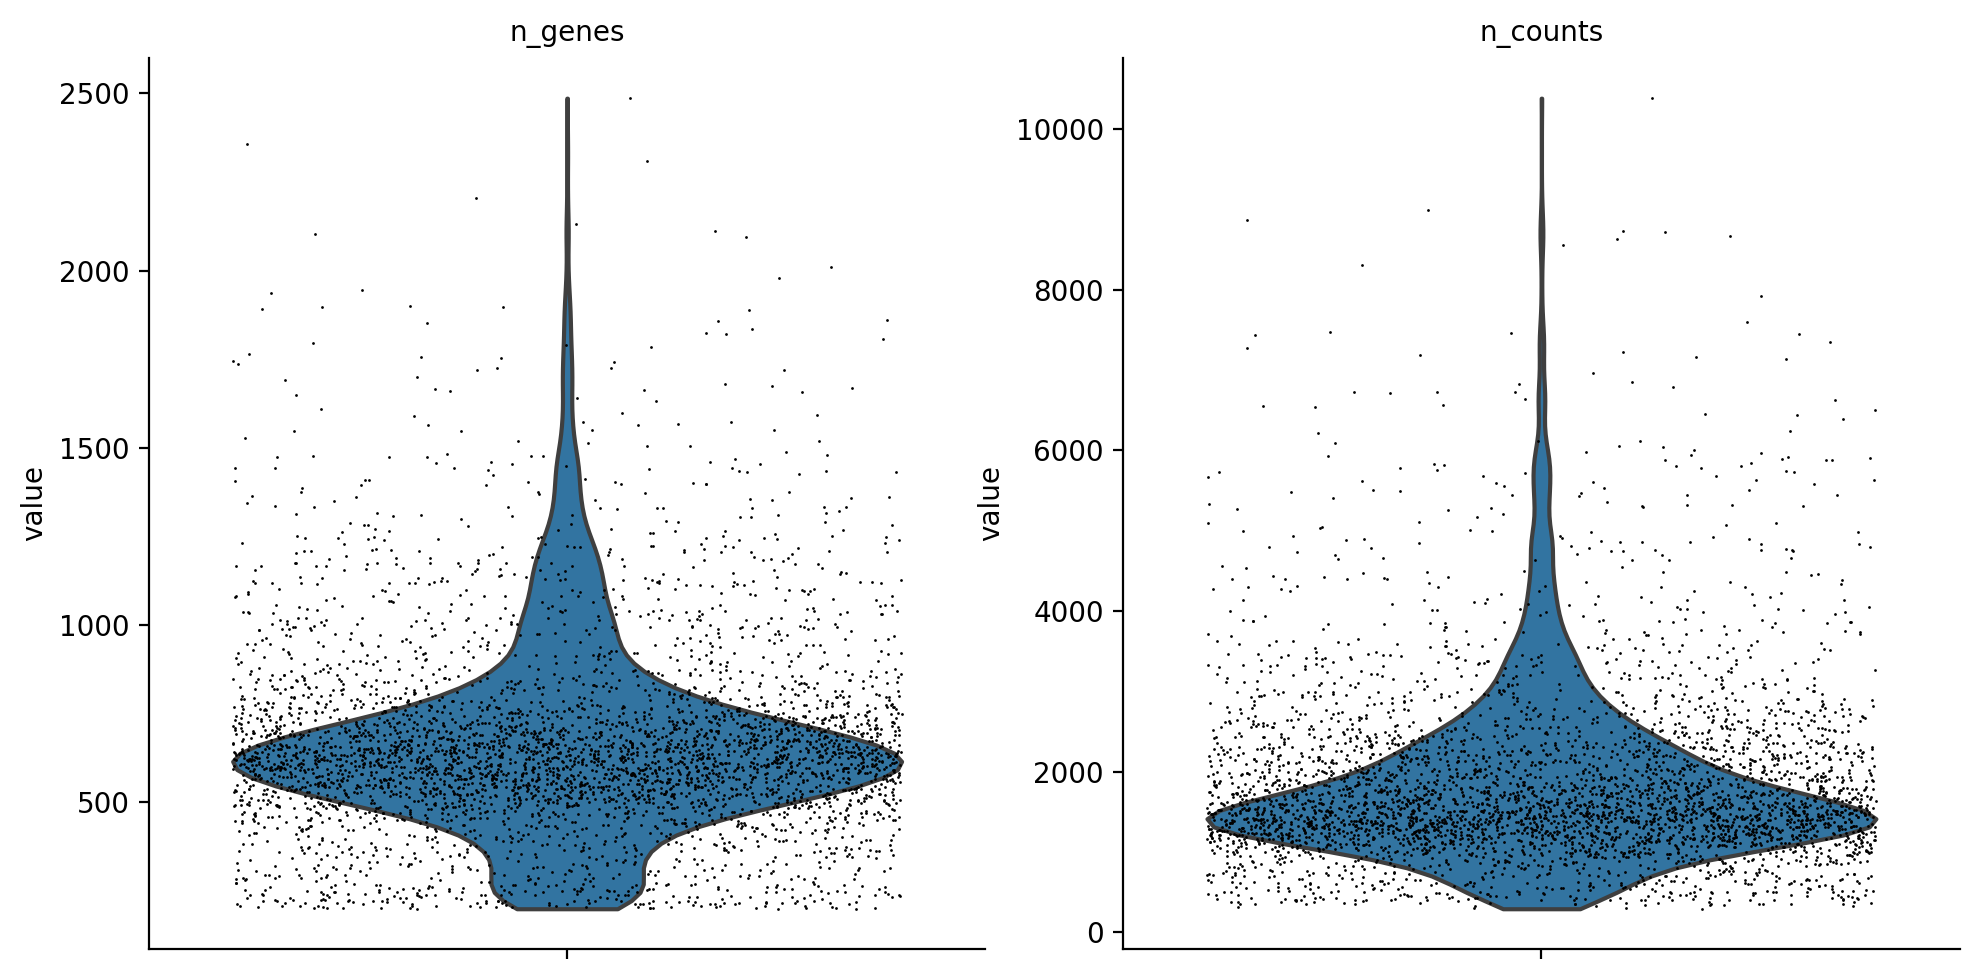

In [26]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

## Normalization

In [27]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## Identify highly variable genes

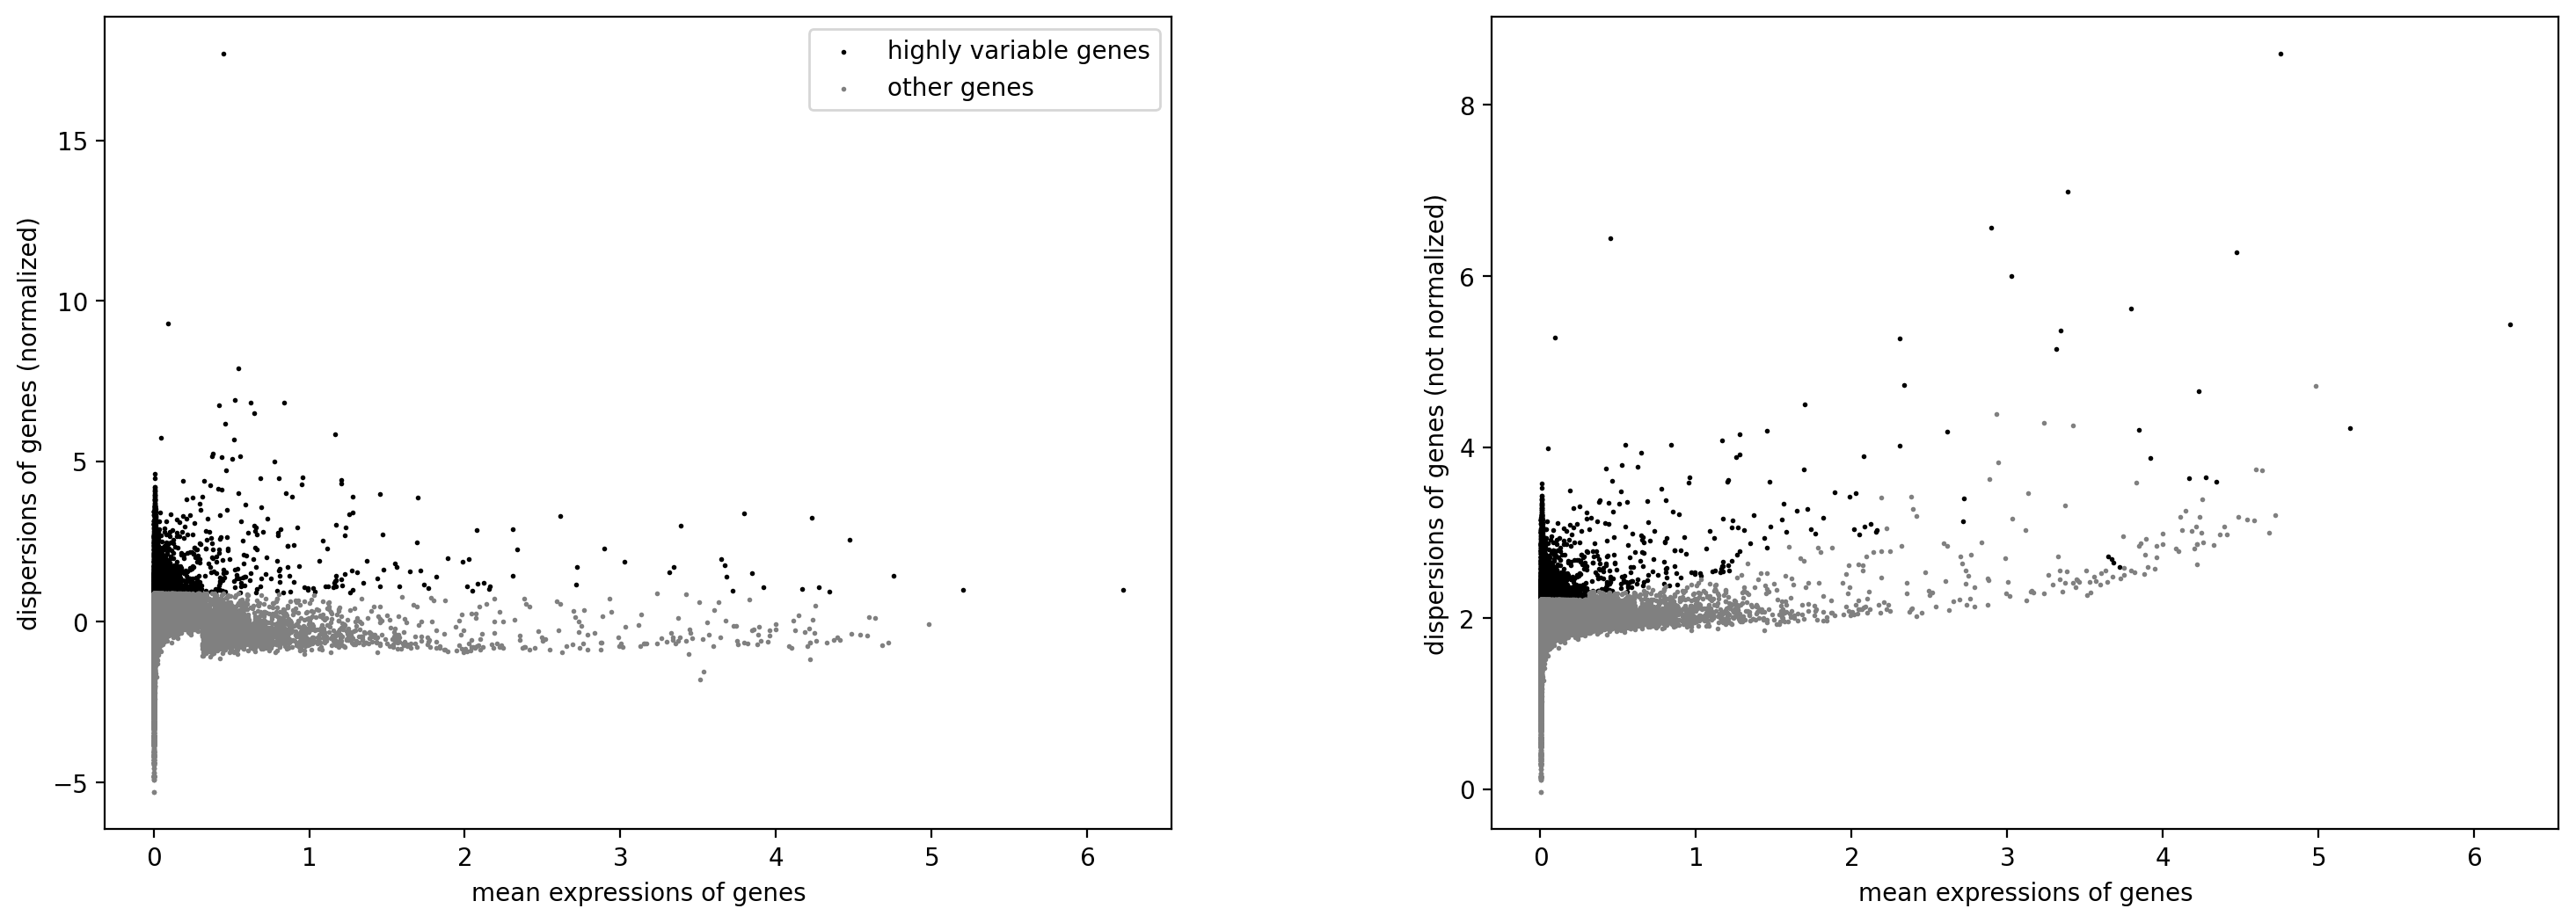

In [28]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [29]:
sc.pp.scale(adata, max_value=10)

## Clustering

In [30]:
adata.var


,gene_name,mito,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_id,,,,,,,,
ENSG00000223972.5,DDX11L1,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
ENSG00000227232.5,WASH7P,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
ENSG00000278267.1,MIR6859-1,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
ENSG00000243485.5,MIR1302-2HG,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
ENSG00000284332.1,MIR1302-2,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
...,...,...,...,...,...,...,...,...
ENSG00000271254.6,AC240274.1,False,False,2.476276e-03,1.911048,0.044163,0.000811,0.03883
ENSG00000275405.1,U1,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000
ENSG00000275987.1,U1,False,False,1.000000e-12,NaN,NaN,0.000000,1.00000


In [31]:
# Louvain clustering
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=40,n_pcs=10, knn=True)
sc.tl.louvain(adata, resolution=0.6)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


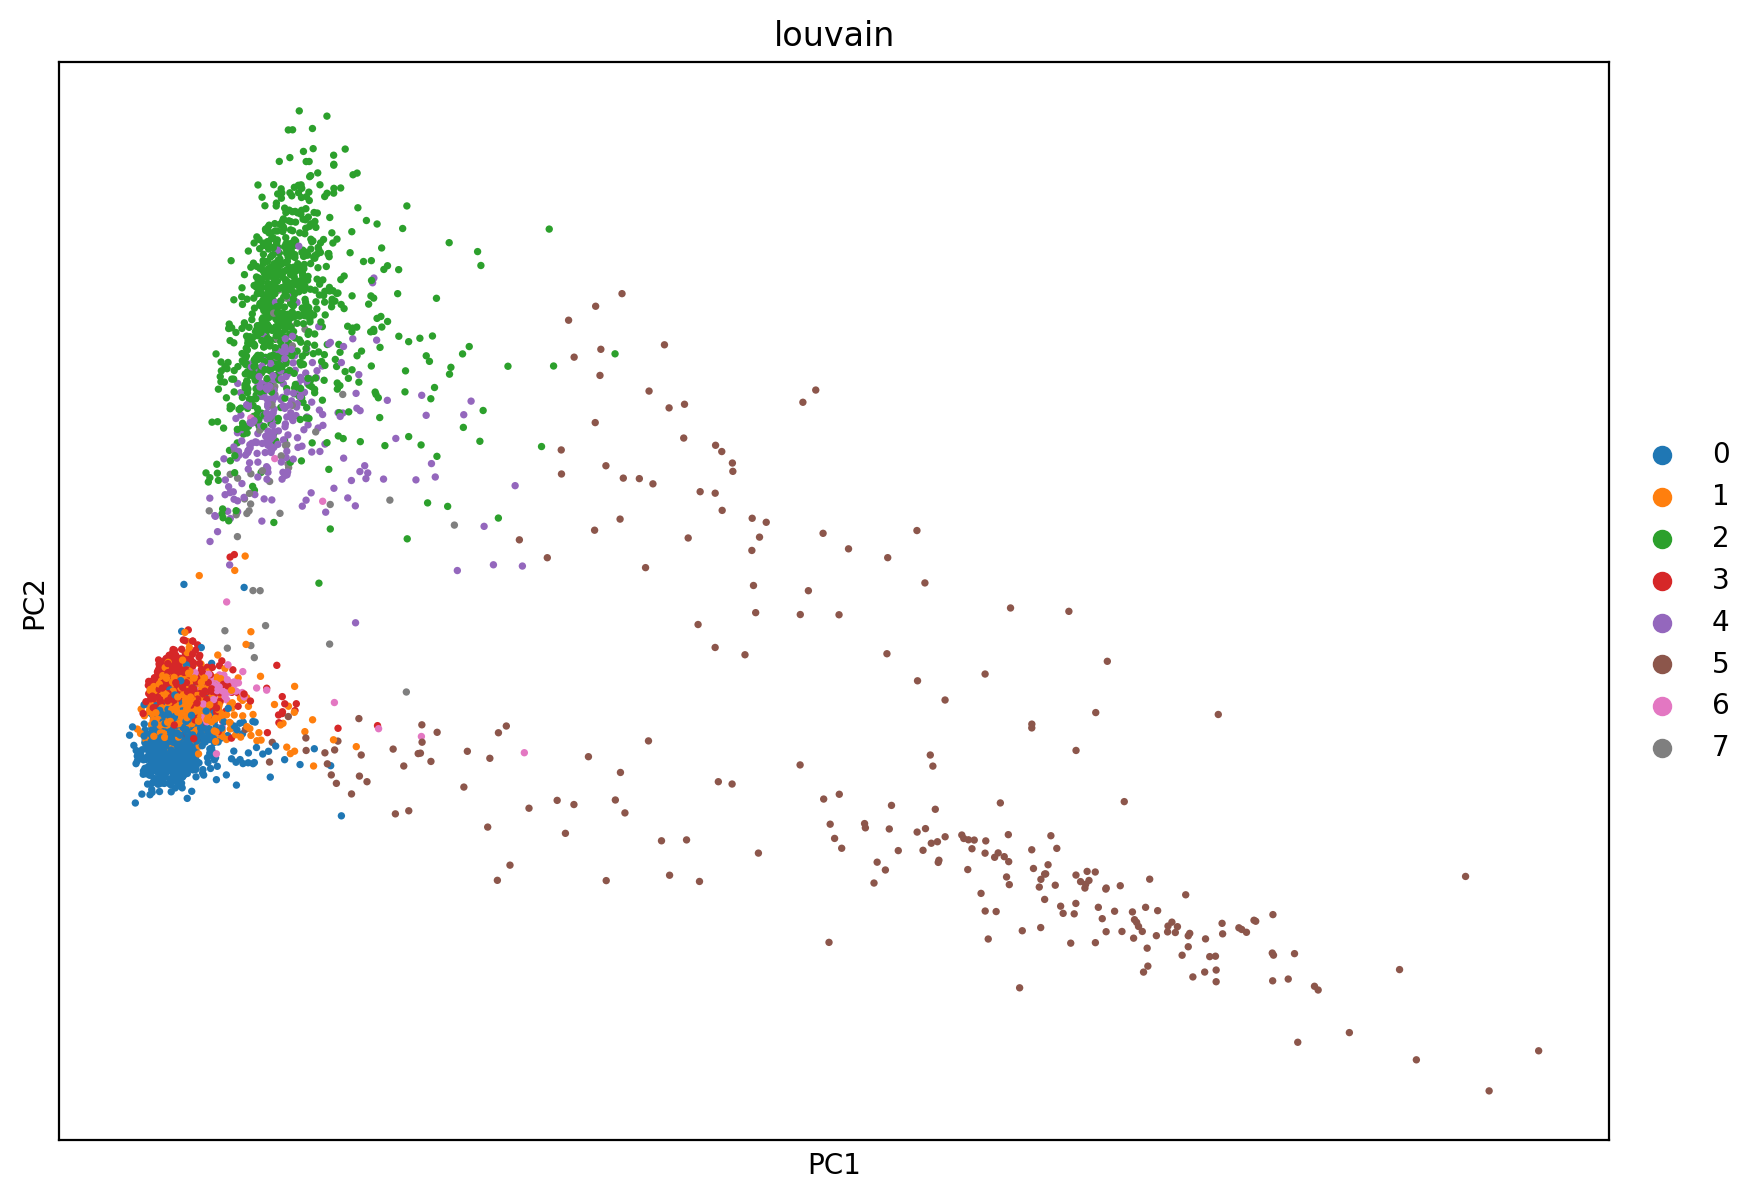

In [32]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

In [33]:
# t-SNE /w top 10 pcs
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


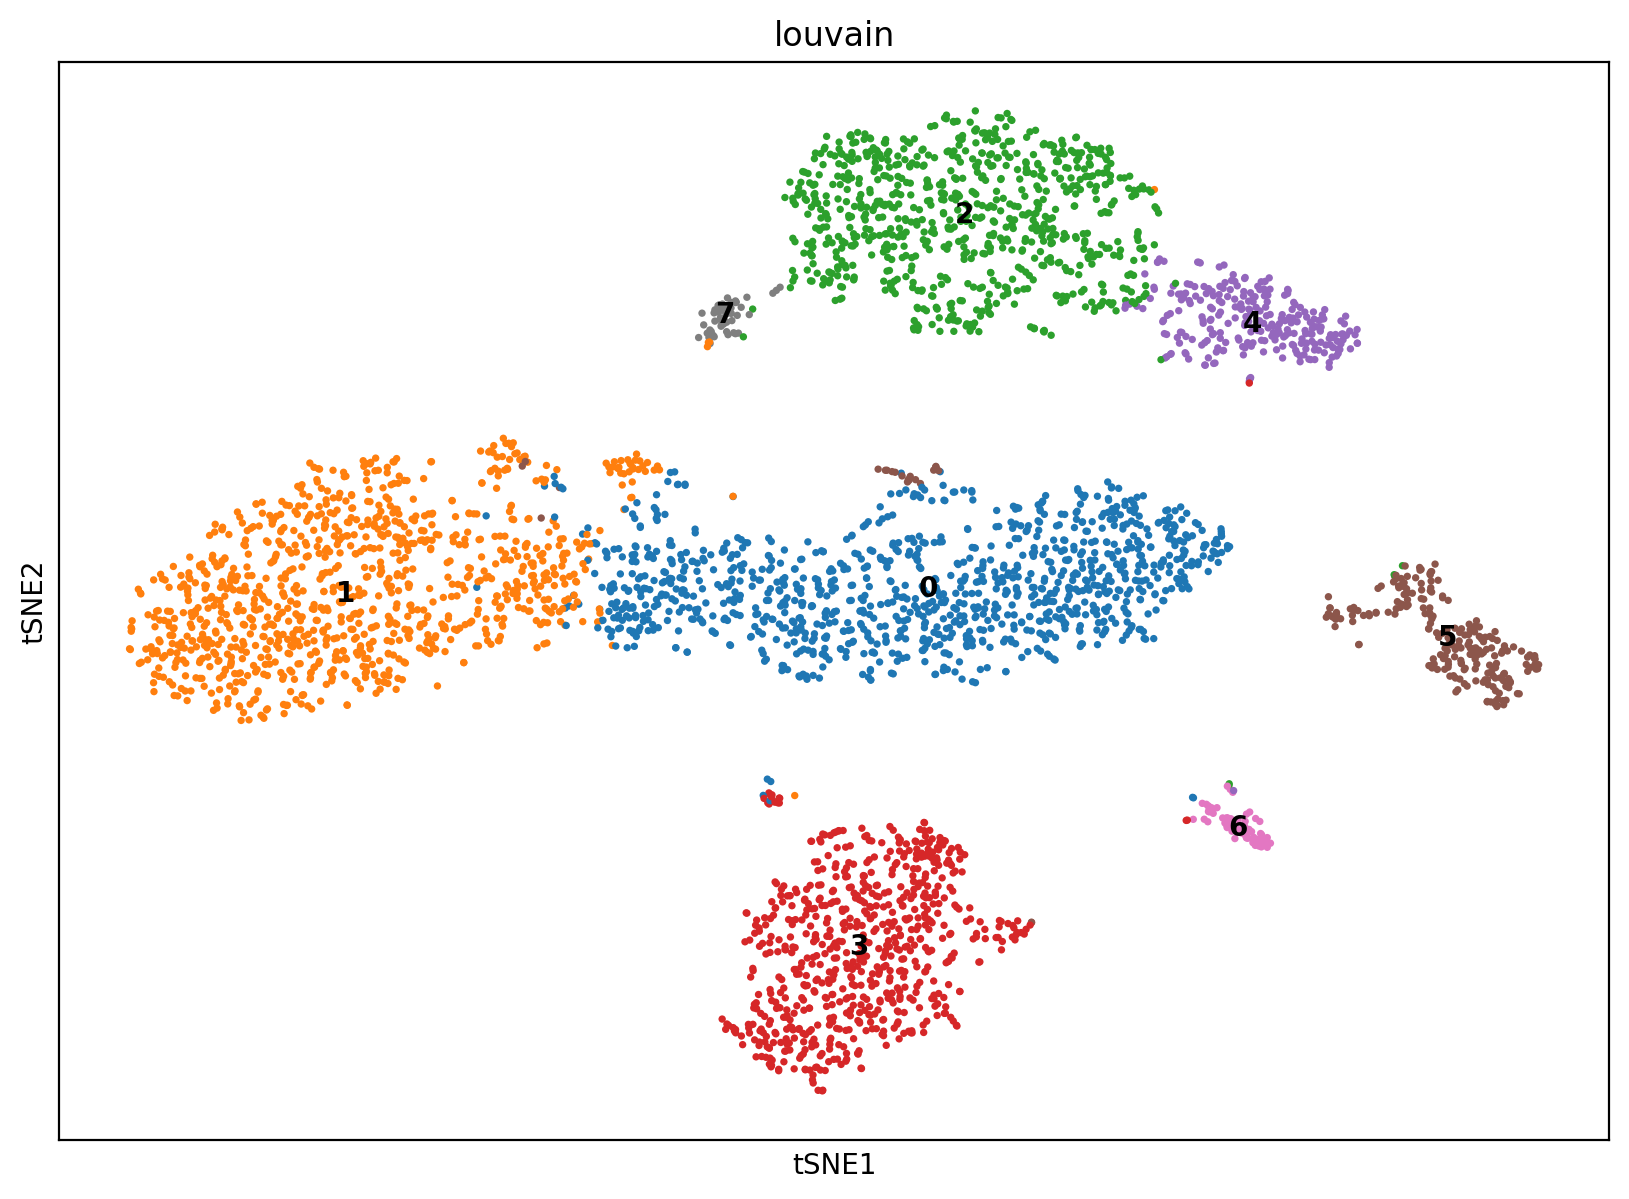

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax, gene_symbols='gene_name', use_raw=False, legend_loc='on data', save='.pdf')

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2

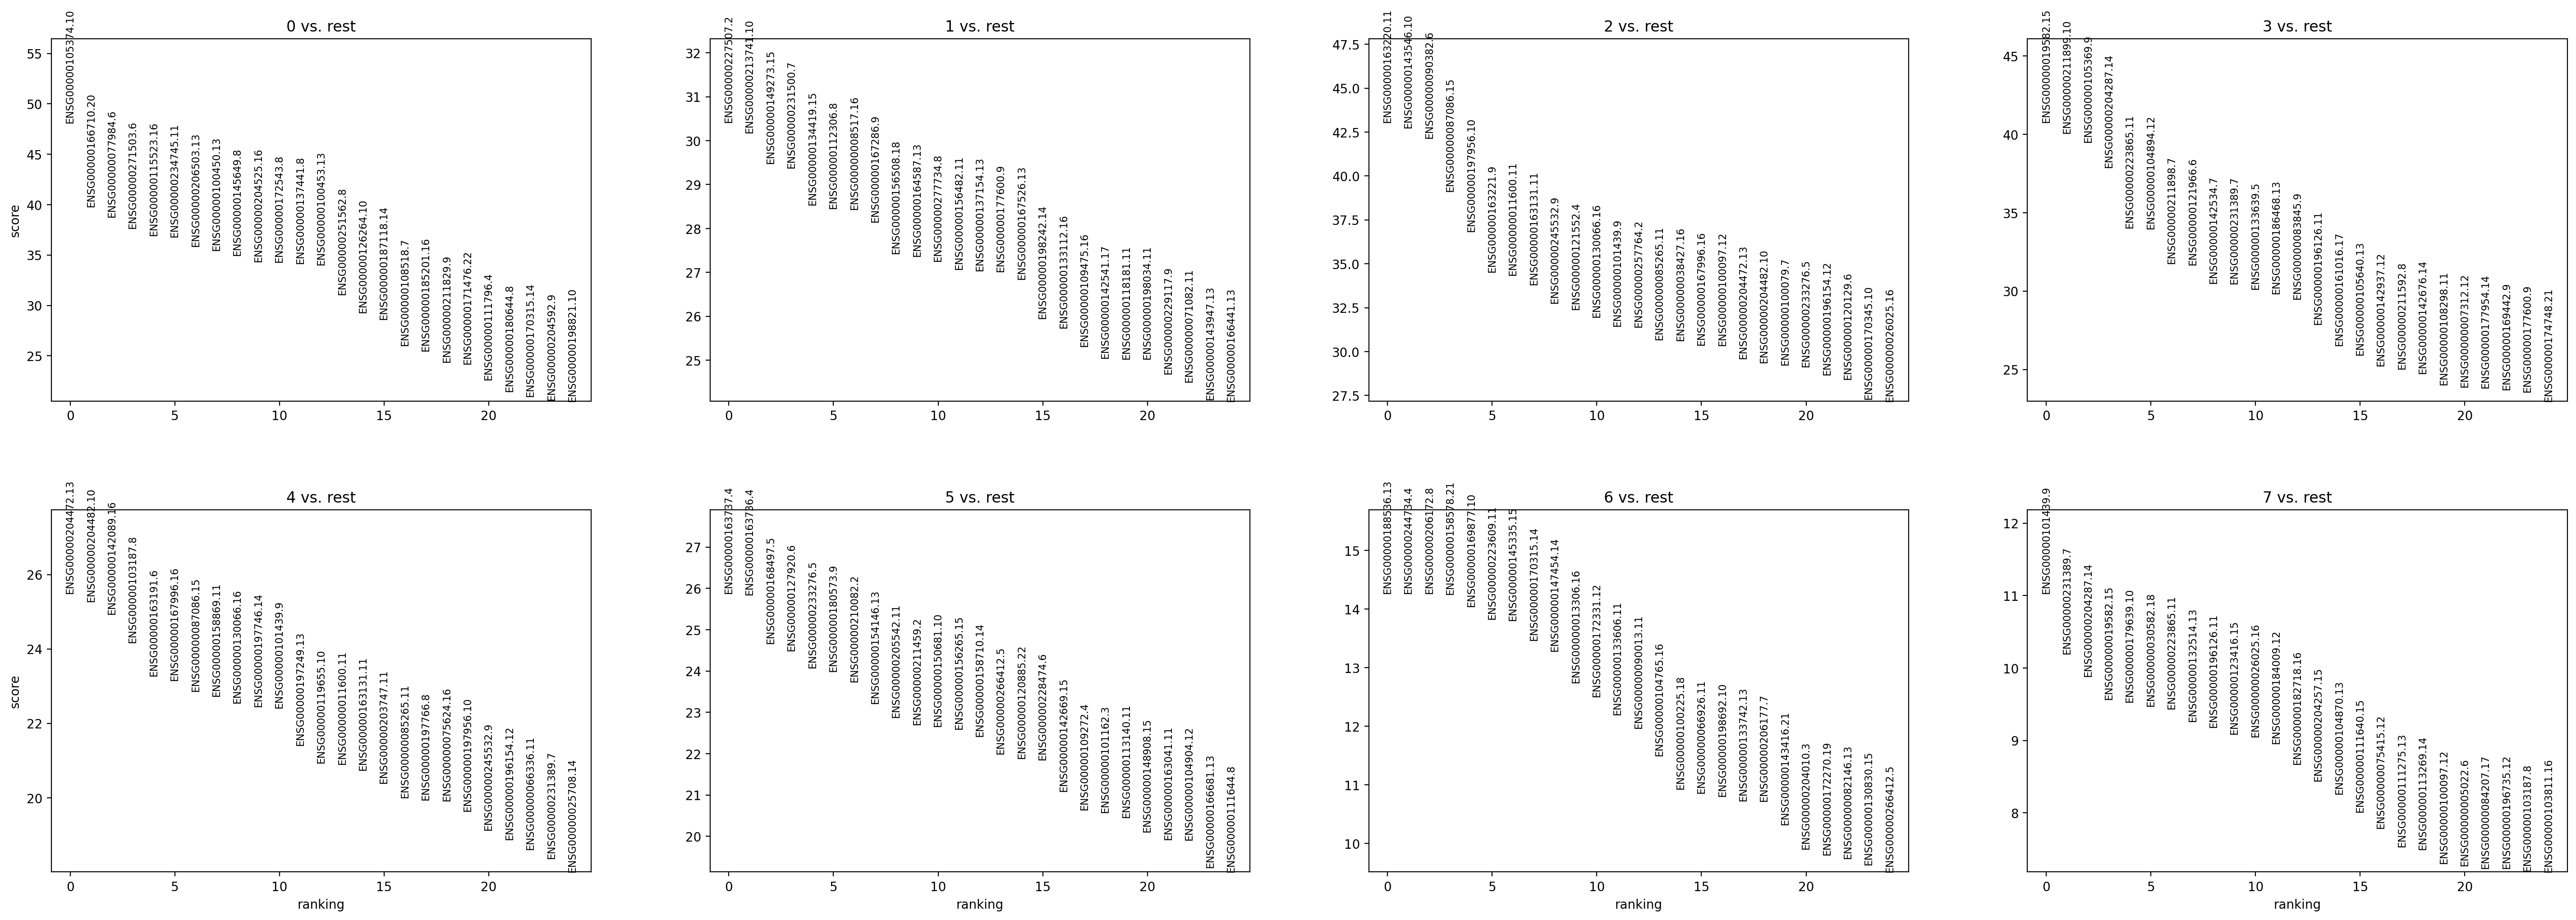

In [35]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
tmp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
tmp = tmp.applymap(lambda x: x.replace(x, g2n[x]))
tmp

,0,1,2,3,4,5,6,7
0,NKG7,LTB,S100A9,CD74,AIF1,PF4,HBA2,CST3
1,B2M,RPS29,S100A8,IGHM,LST1,PPBP,HBB,HLA-DPA1
2,CST7,RPS3,LYZ,CD79A,IFITM3,CAVIN2,HBA1,HLA-DRA
3,CCL5,RPS18,FTL,HLA-DRA,COTL1,GNG11,ALAS2,CD74
4,GNLY,RPS15A,S100A6,HLA-DPB1,S100A11,GPX1,AHSP,FCER1A


/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


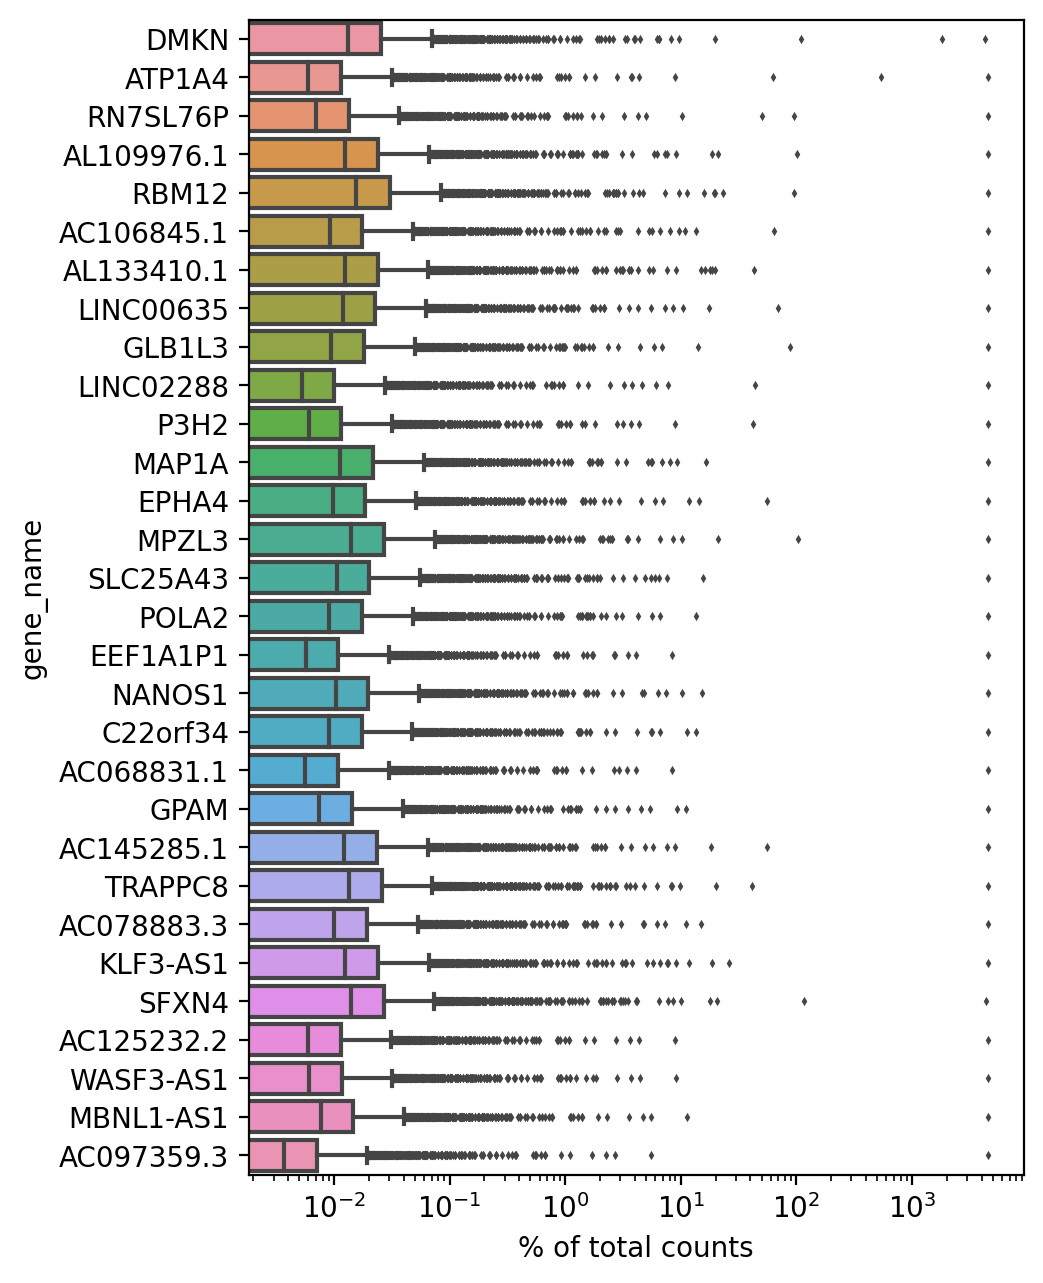

In [37]:
sc.pl.highest_expr_genes(adata, log=True, gene_symbols='gene_name')

In [38]:
# qc_filtered[0].describe()
adata.obs

,n_genes,n_counts,louvain
barcode,,,
AAACCTGAGCCGGTAA,634,1453.0,0
AAACCTGAGCCTCGTG,652,1486.0,2
AAACCTGCAGCGAACA,502,1229.0,3
AAACCTGGTATAGGGC,585,1204.0,0
AAACCTGGTCTAGCCG,614,1283.0,0
...,...,...,...
TTTGTCAAGGAATTAC,238,5503.0,6
TTTGTCAAGTGCGTGA,530,1095.0,0
TTTGTCACACGAGGTA,580,1302.0,1


In [39]:
adata.var[adata.var['highly_variable']==True].describe()

,means,dispersions,dispersions_norm,mean,std
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.128162,2.502392,1.602455,0.054067,0.184992
std,0.413283,0.373873,0.823196,0.287323,0.213004
min,0.002164,2.222470,0.900289,0.000546,0.035624
25%,0.008377,2.288892,1.072484,0.001968,0.067145
50%,0.023781,2.390546,1.337487,0.006419,0.116081
75%,0.072594,2.590997,1.864694,0.020887,0.206419
max,6.231281,8.595427,17.695892,5.807292,2.059117


## The problem 

观察gene_cell matrix 统计以及quality check数据发现，每个细胞包含多个基因表达，然而表达程度极低（表达程度中位数=0.023）。
细胞根据umi count以及线粒体蛋白基因总表达<0.5过滤后仅剩800多个细胞（过滤前14000+）。
目前总结可能的原因：

1. kallisto pesudoalignment 过程本身准确度低

2. 目前使用的reference index 版本不匹配(v96, GRCh38.p12), 或者需要intronic reference index

3. 在kallisto-bustools 生成 cell_gene matrix过程中处理umi collision方式导致表达被稀释（目前代码使用的是kallisto tutorial中使用的算法，在这个notebook里有实现）

4. kallisto pipeline里并未对umi进行校正，虽然在相关paper里作者表示：

```    
12-base-pair UMIs only 0.5% and 0.6% of reads would be recovered
```

关于kallisto-bustools运行命令细节，参考count_out文件夹下kb_info.json, inspect.json


kallisto-bustools 论文：https://doi.org/10.1038/s41587-021-00870-2